# Titanic Dataset Exploration

# Introduction

Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn to improve my data analysis and visualization skills.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
import re
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV as rscv
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = None
pd.options.display.max_rows = 30

filepath = 'D:/code/Data/titanic/'

titanic = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

# Also, we're going to need the test ids for submission, so let's grab those

test_id = test['PassengerId']

I'm doing this Kaggle competition:  
https://www.kaggle.com/c/titanic/overview

I'm going to create a machine learning model to predict whether or not a passenger survived based on information like sex, class, and age.

Also, in general, when I've looked up information on the passengers, it's been through:  
https://www.encyclopedia-titanica.org/

# Exploring the Data

In [2]:
display(titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here's some explanations about the data, taken from the datafiles

Data Dictionary:  


Variable	Definition	Key  
survival	Survival	0 = No, 1 = Yes  
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex	Sex	  
Age	Age in years	 
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  

Variable Notes  
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Let's clean up the missing data:

# Data Cleaning

Let's check missing numbers, impute where needed.

In [3]:
display(titanic.isnull().sum())
print('')
display(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Cabin

Well shoot! We're missing most of the cabin info (There's only 891 rows total). Let's drop it. I guess we could come back and manually add that in someday, but that seems like a waste of time.

In [4]:
titanic = titanic.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

## Embarked

Let's see which Embarked Locations are missing. We might be able to look those up online.

In [5]:
for i, row in titanic.iterrows():
    if row.isnull().Embarked:
            print(row)

PassengerId                     62
Survived                         1
Pclass                           1
Name           Icard, Miss. Amelie
Sex                         female
Age                             38
SibSp                            0
Parch                            0
Ticket                      113572
Fare                            80
Embarked                       NaN
Name: 61, dtype: object
PassengerId                                          830
Survived                                               1
Pclass                                                 1
Name           Stone, Mrs. George Nelson (Martha Evelyn)
Sex                                               female
Age                                                   62
SibSp                                                  0
Parch                                                  0
Ticket                                            113572
Fare                                                  80
Embarked             

1. Miss Rose Amélie Icard boarded the Titanic at Southampton as maid to Mrs George Nelson Stone.  
2. Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.  

So let's set both of their Embarked values to 'S'.

In [6]:
titanic.loc[61, 'Embarked'] = 'S'
titanic.loc[829, 'Embarked'] = 'S'

In [7]:
for i, row in test.iterrows():
    if row.isnull().Embarked:
            print(row)

## Age

Hmm, age could be a bit trickier. Let's just impute the mean age to all the missing for now. Some day when we have more time we could actually look up all the missing ages and put them in. Or we could impute seperately for Men vs Women.

In [8]:
# I'm a little confused as to why this worked, but whatever.
titanic['Age'] = SimpleImputer().fit_transform(titanic[['Age']])
test['Age'] = SimpleImputer().fit_transform(test[['Age']])

## Fare

Also, one of the test cases is missing their fare, so just impute that as well.

In [9]:
test['Fare'] = SimpleImputer().fit_transform(test[['Fare']])

## Check

In [10]:
display(titanic.isnull().sum())
print('')
display(test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [11]:
display(titanic)
display(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,S


Ok, we're good to go!

# Plotting the Data

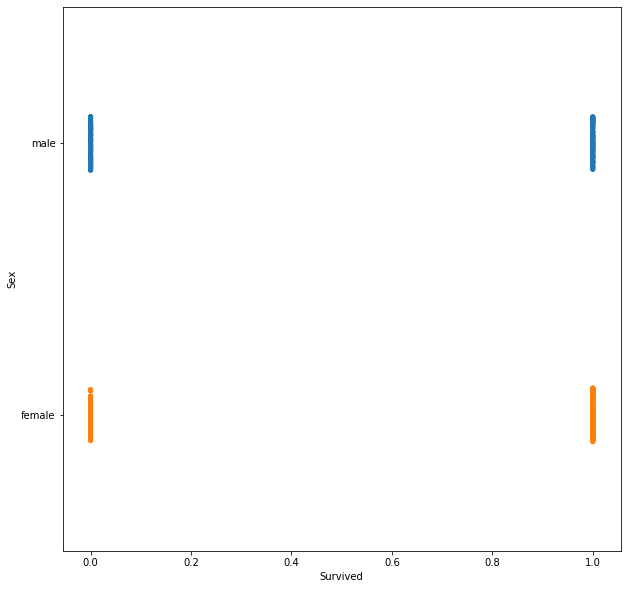

In [12]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'Survived', y = 'Sex', data = titanic)
plt.show()

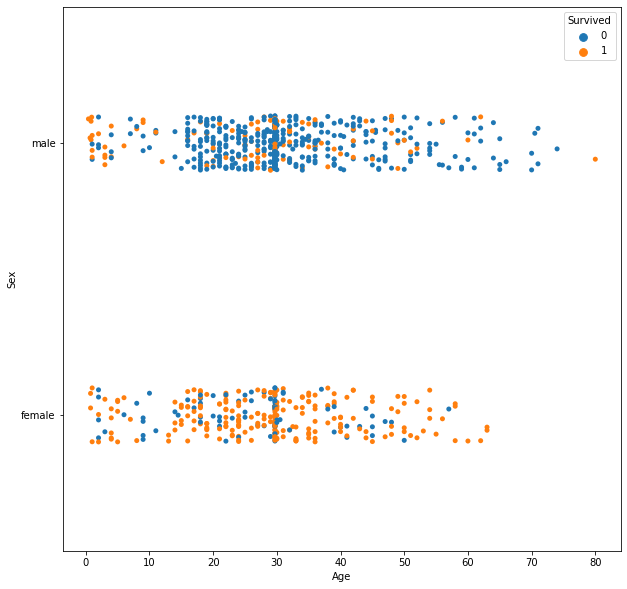

In [13]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'Age', y = 'Sex', hue = 'Survived', data = titanic)
plt.show()

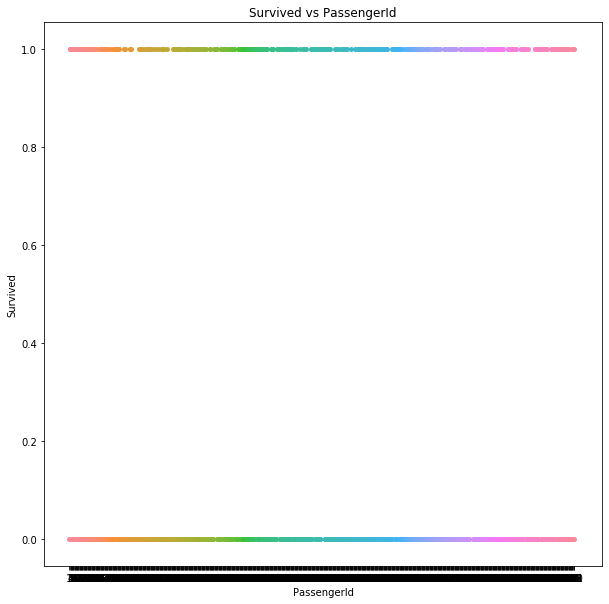

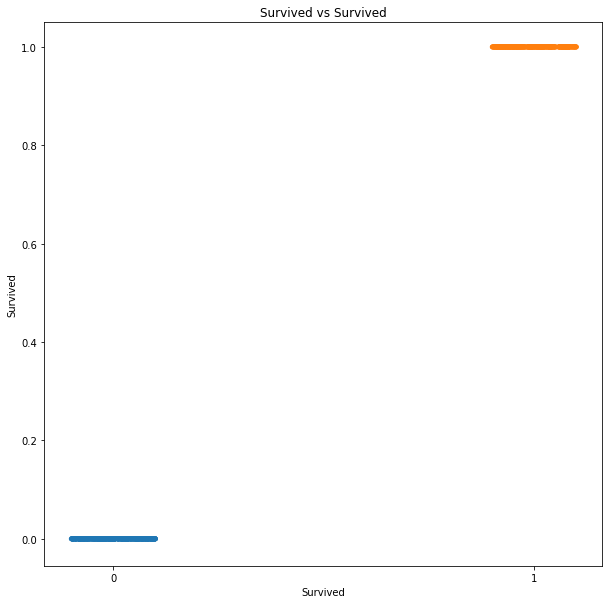

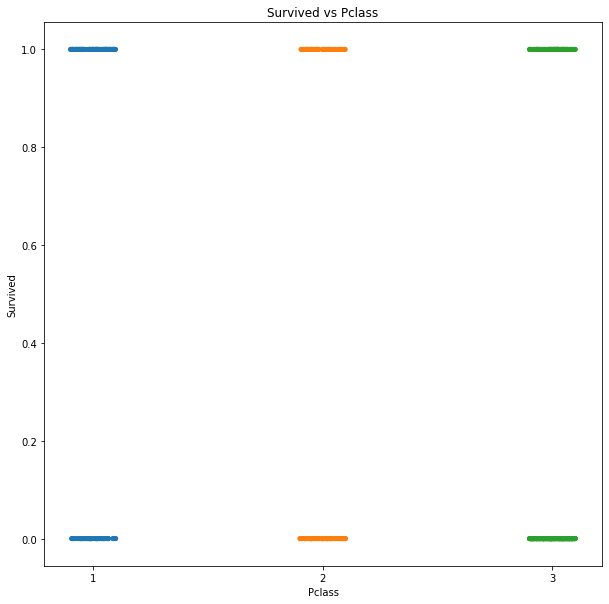

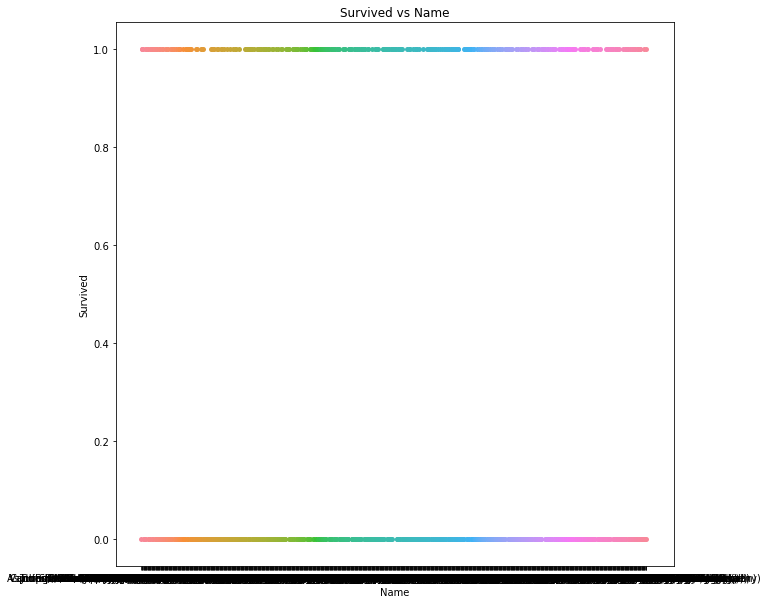

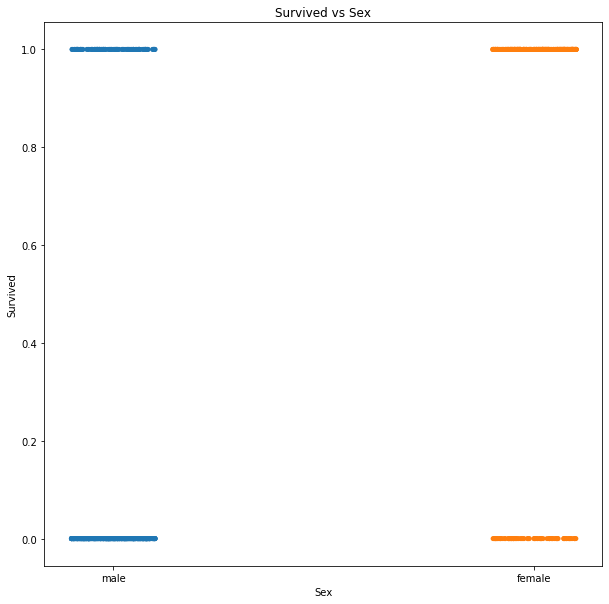

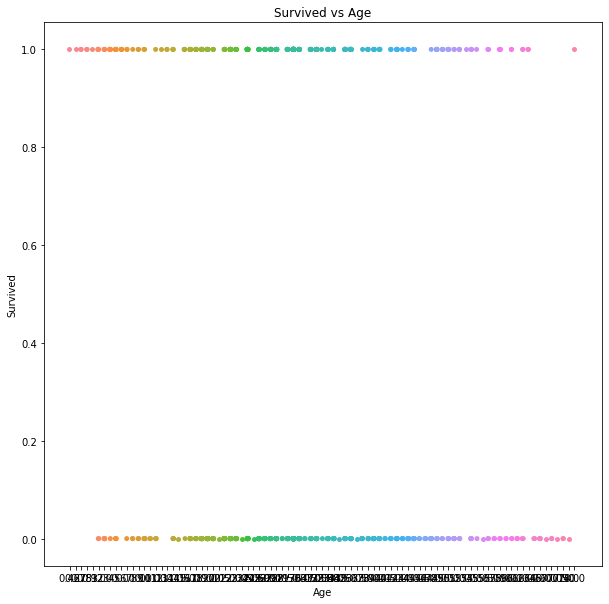

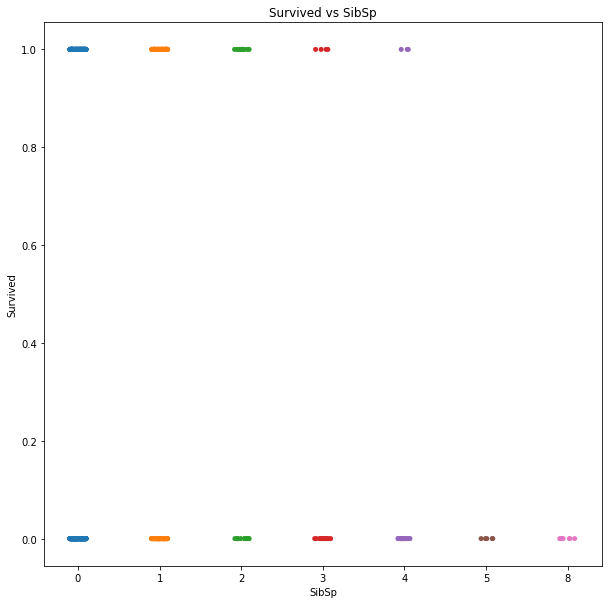

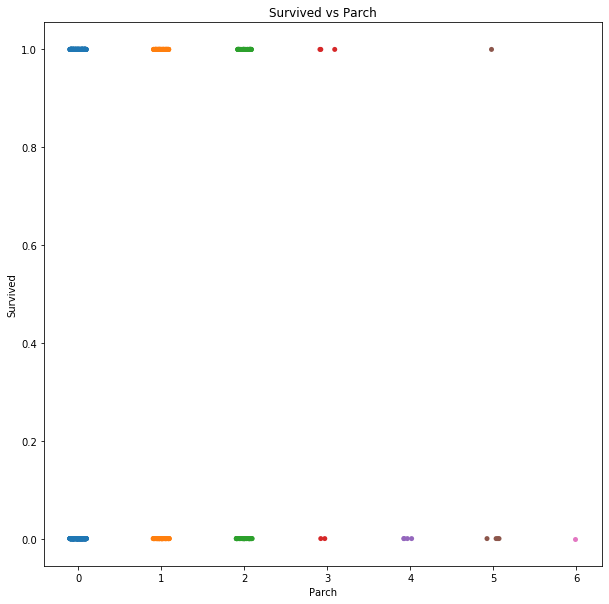

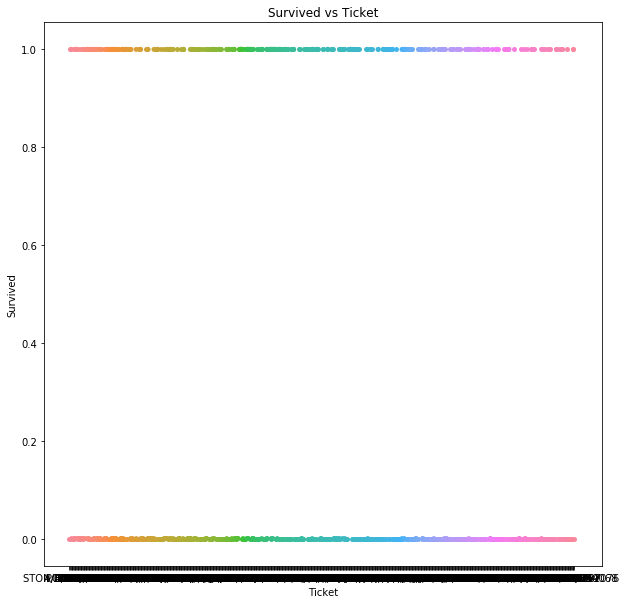

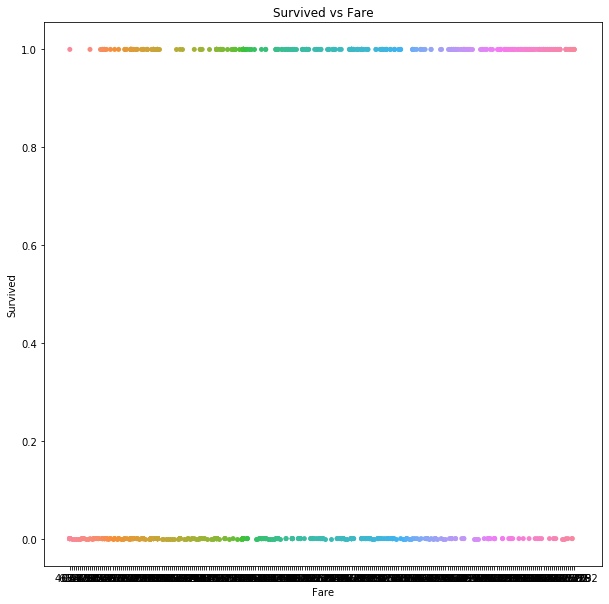

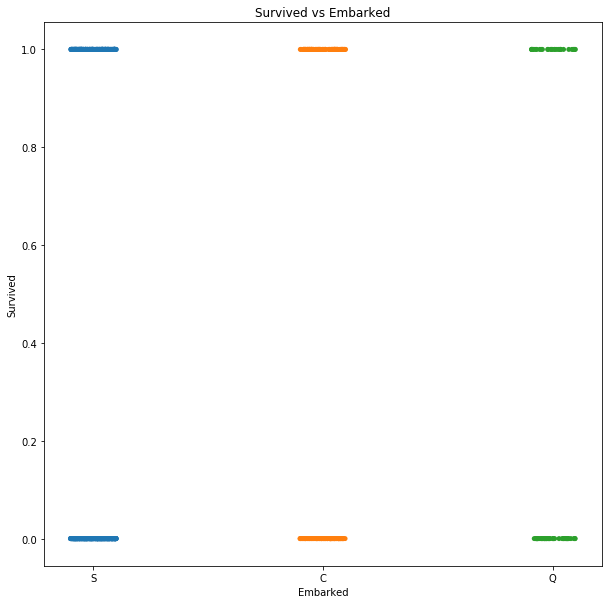

In [14]:
for feature in titanic:

    plt.figure(figsize = (10, 10))
    graph = sns.stripplot(x = feature, y = 'Survived', hue = None, data = titanic)
    plt.title(f'Survived vs {feature}')
    graph.autoscale()
    plt.show()

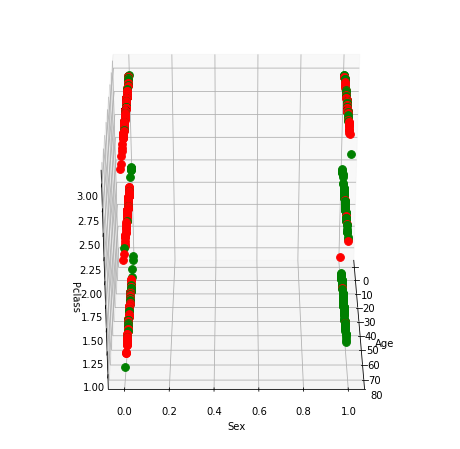

In [15]:
xs = titanic['Age']
ys = titanic['Sex'].apply(lambda x : 0 if x =='male' else 1)
zs = titanic['Pclass']
label = titanic['Survived']
data = zip(xs, ys, zs, label)

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')

for x, y, z, l in data:
    if l == 0:
        color = 'red'
    else:
        color = 'green'
    ax.scatter(x, y, z, s=60, label = l, c = color)

ax.view_init(30, 185)
ax.set_xlabel('Age')
ax.set_ylabel('Sex')
ax.set_zlabel('Pclass')

def animate(i):
    ax.view_init(30, i)
    return plt.draw()

anim = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = False)
    
HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())

Wow! What a beautiful graph I've made!!  

From this, we can already draw a few conclusions:  

1. Seems like Men died more, 2nd and 3rd class folks died more, and the yong and old lived more.

# Feature Generation

Most of the features appear good to go. However, there is one feature that we can extract: the honorifics of the person: Mr., Mrs., Dr., etc...  

I guess I'll go through it and construct a list of all the possible prefixes...  

Lol, no! I'm a programmer, not a monkey! Let's write some code to do that:

Damn. Guess I have to learn regex now (regular expressions).

No, regex is hard! How about you: split the words, return each unique word that contains a '.'

In [16]:
honorifics = set()
for name in titanic['Name']:
    words = name.split()
    for word in words:
        if '.' in word:
            honorifics.add(word)
                      
display(honorifics)

honorifics_test = set()
for name in test['Name']:
    words = name.split()
    for word in words:
        if '.' in word:
            honorifics_test.add(word)
            
display(honorifics_test)

{'Capt.',
 'Col.',
 'Countess.',
 'Don.',
 'Dr.',
 'Jonkheer.',
 'L.',
 'Lady.',
 'Major.',
 'Master.',
 'Miss.',
 'Mlle.',
 'Mme.',
 'Mr.',
 'Mrs.',
 'Ms.',
 'Rev.',
 'Sir.'}

{'Col.', 'Dona.', 'Dr.', 'Master.', 'Miss.', 'Mr.', 'Mrs.', 'Ms.', 'Rev.'}

Now that's what I call coding! It mostly looks good. But, what about 'Don.', 'Jonkheer.', 'L.', 'Mlle.', 'Mme.'? Let's check each of these.

Based on my research / googling, 'Mlle.' is short for mademoiselle, which is French for 'Ms.'

'Mme.' is French for 'Madame.', which might be the same as Mrs.? Unclear.

Jonkheer (female equivalent: jonkvrouw; French: Écuyer) is an honorific in the Low Countries denoting the lowest rank within the nobility.

"Don' is an honorific in Mexico and other countries.

However, 'L.' is just an abbreviated middle name, so we'll remove it from the list.

For now let's keep the French and English prefixes together. But it might work better to combine some.

In [17]:
for i, row in titanic.iterrows():
    for honor in ['Don.', 'Jonkheer.', 'L.']:
        if honor in row['Name'].split():
            print(row)
            investigate.append(row)
            
display(investigate)

PassengerId                          31
Survived                              0
Pclass                                1
Name           Uruchurtu, Don. Manuel E
Sex                                male
Age                                  40
SibSp                                 0
Parch                                 0
Ticket                         PC 17601
Fare                            27.7208
Embarked                              C
Name: 30, dtype: object


NameError: name 'investigate' is not defined

Let's make sure that no one has more or less than one prefix.

In [18]:
honorifics.remove('L.')
display(honorifics)

{'Capt.',
 'Col.',
 'Countess.',
 'Don.',
 'Dr.',
 'Jonkheer.',
 'Lady.',
 'Major.',
 'Master.',
 'Miss.',
 'Mlle.',
 'Mme.',
 'Mr.',
 'Mrs.',
 'Ms.',
 'Rev.',
 'Sir.'}

In [19]:
for i, row in titanic.iterrows():
    count = 0
    for honor in list(honorifics):
        if honor in row['Name'].split():
            count += 1
    if count != 1:
        print(i, count)

In [20]:
for i, row in test.iterrows():
    count = 0
    for honor in list(honorifics):
        if honor in row['Name'].split():
            count += 1
    if count != 1:
        print(i, count)

414 0


Good, looks like we're set to add this feature. Well, except this annoying lady:  
Doña Fermina Oliva y Ocana, 39, was born on 12 October 1872, in Madrid, Spain.
She boarded the Titanic at Cherbourg as maid to Mrs Victor de Satode Peñasco y Castellana.

We'll give her the title 'Ms.' by hand.

Ok, we need to standardize these labels if we want to do one-hot later on.

In [21]:
# # Eh, gonna take a while to fix this. Let's just ignore this for now

# def extract_honor(string):
#     for honor in honorifics:
#         if honor in string.split():
#             if honor in
            
#             elif
            
            
#             else return honor
    
# titanic['Honorific'] = titanic['Name'].apply(extract_honor)
# test['Honorific'] = test['Name'].apply(extract_honor)

In [22]:
# test.loc[414, 'Honorific'] = 'Ms.'

In [23]:
display(titanic)
display(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,S


Yes! Our data looks beautiful. Let's get to work.

# Correlation Matrix



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.033207,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500
Age,0.033207,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566
SibSp,-0.057527,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000


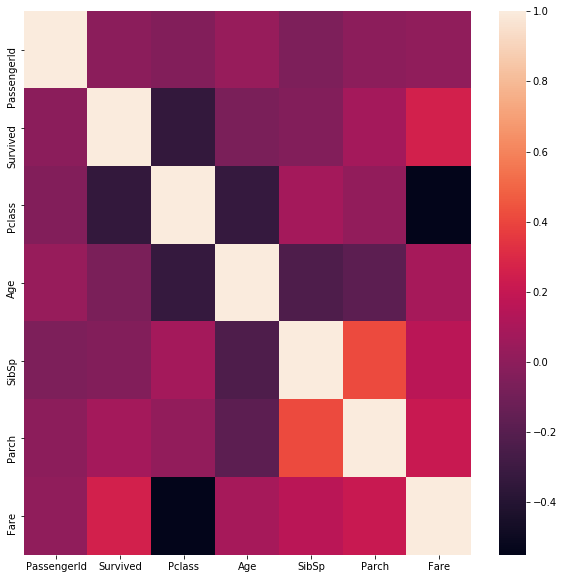

<Figure size 720x720 with 0 Axes>

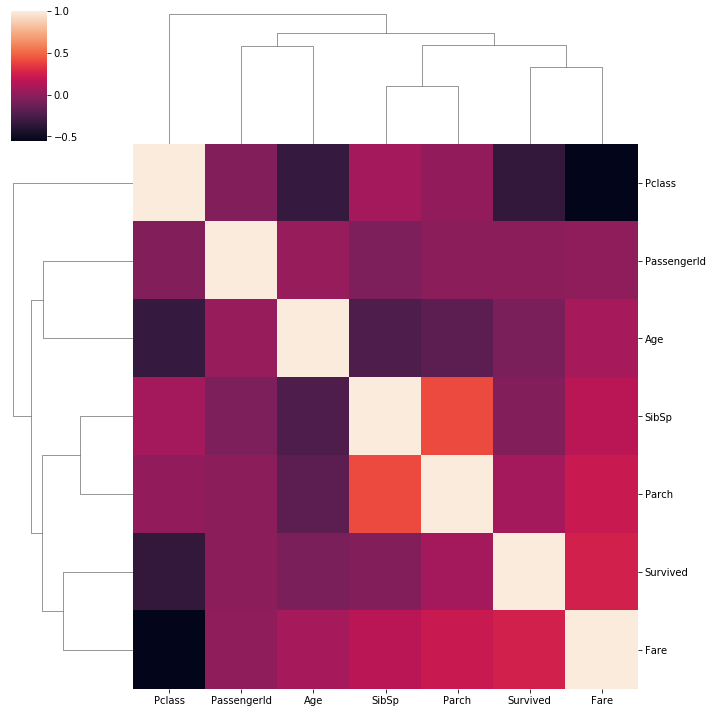

In [24]:
corr = titanic.corr()
display(corr)

plt.figure(figsize = (10, 10))
sns.heatmap(corr)
plt.show()

plt.figure(figsize = (10, 10))
sns.clustermap(corr)
plt.show()

# LightGBM

Let's chuck it in a Light GBM Random Search, and see what we come up with.

Ok, we're done with names and passenger ids now, so let's drop those. And ticket number doesn't seem that useful.

In [25]:
titanic = titanic.drop(['Name', 'PassengerId', 'Ticket'], axis = 1)
test = test.drop(['Name', 'PassengerId', 'Ticket'], axis = 1)

And, despite it SAYING IT CAN HANDLE CATEGORICAL FEATURES IN THE DOCUMENTATION, LightGBM keeps freaking out. So I'd better encode Sex, Embarked, and Honorific. Let's do Label Encoding.

In [26]:
# Actually, let's do one hot

titanic = pd.get_dummies(titanic)
test = pd.get_dummies(test)





# titanic['Sex'] = LabelEncoder().fit_transform(titanic['Sex'])
# titanic['Embarked'] = LabelEncoder().fit_transform(titanic['Embarked'])
# # titanic['Honorific'] = LabelEncoder().fit_transform(titanic['Honorific'])

# test['Sex'] = LabelEncoder().fit_transform(test['Sex'])
# test['Embarked'] = LabelEncoder().fit_transform(test['Embarked'])
# # test['Honorific'] = LabelEncoder().fit_transform(test['Honorific'])

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  92 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 692 tasks      | elapsed:   51.4s
[Parallel(n_jobs=2)]: Done 1692 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 2884 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 3784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done 4774 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:  6.3min finished


Best score reached: 0.8728717487647776 with params: {'num_leaves': 3, 'n_estimators': 267, 'learning_rate': 0.03} 


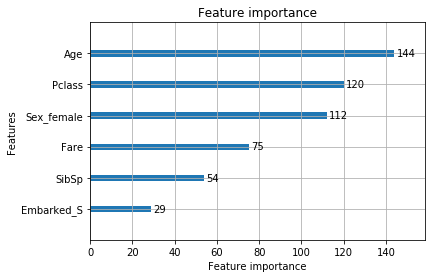

In [27]:
X_data = titanic.drop('Survived', axis = 1)
y_data = titanic['Survived']

X_test = test

param_test = {
                'num_leaves': range(2, 20), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 1000, 1),
#                'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }


model = lgb.LGBMClassifier(silent=True, n_jobs=3, verbose = -1)


rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='roc_auc',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 1000,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMClassifier(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'PassengerID': test_id, 'Survived': predict})

output.to_csv(f'{filepath}submit1.csv',index=False, header =1)

lgb.plot_importance(model)
plt.show()

Well, all my effort was for naught, because I freaking flew up the leaderboard by doing the following:

Label Encode + honorific = 14000 place, 0.78947 accuracy  
Label Encode - honorific = 9800 place, 0.77511 accuracy  
One Hot - Honorific = 3740 place, 0.74162 accuracy  


Best score reached: 0.8727809033103033 with params: {'num_leaves': 3, 'n_estimators': 127, 'learning_rate': 0.06}  
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:  4.9min finished  
Above, but 1000 rs iterations =  0.77511 accuracy, not an improvement